# MBI

In [1]:
from sklearn.preprocessing import MinMaxScaler

In [2]:
import numpy as np

In [3]:
def calc_r(m0, j=999):
    
    if j != 999:
        r = (m0[j+1] - m0[j])/(m0[j+1] + m0[j])
    else:
        r = []
        for i in range(1, len(m0)):

            num = m0[i] - m0[i-1]
            den = m0[i] + m0[i-1]
            r_temp = num/den
            r.append(r_temp)
        r = np.array(r)
    
    return r

In [4]:
def calc_G(m0, r0, r, step=.01, objective = 'Z'):
    
    G = np.zeros((len(m0), len(r0))) # 4x3 
    for j, row in enumerate(G): # for each row
        for i, col in enumerate(G[j]): # for each column
            if (i == j): # changes m_first
                m_first = m0[j]
                m_second = m0[j+1]
                dZ = m_first*step
                r_old = r0[i]
                r_new = (m_second - (m_first+dZ))/(m_second + (m_first+dZ))
                dr = r_old - r_new
                cell_value = dr/dZ
            elif (i==(j-1)): # changes m_second
                m_first = m0[j-1]
                m_second = m0[j]
                dZ = m_second*step
                r_old = r0[i]
                r_new = ((m_second+dZ) - m_first)/((m_second+dZ) + m_first)
                dr = r_old - r_new
                cell_value = dr/dZ
            else:
                cell_value = 0
            G[j][i] = cell_value
            
    if objective == 'Z':
        G = G.T
    else:
        pass
    
    return G

In [5]:
def L1_error(y_true, y_pred):
    n = len(y_true)
    # Calculate the absolute percentage error for each data point
    abs_percentage_error = np.abs((y_pred - y_true) / y_true)
    
    # Calculate the mean absolute percentage error as a percentage of n
    L1 = (np.sum(abs_percentage_error) / n) * 100
    #print(f"L1 error: {L1:.2f}%")
    return L1

def L2_error(y_true, y_pred):
    n = len(y_true)
    # Calculate the squared percentage error for each data point
    squared_percentage_error = ((y_true - y_pred) / y_true) ** 2
    
    # Calculate the mean squared percentage error and take the square root as a percentage of n
    L2 = (np.sqrt(np.sum(squared_percentage_error)) / n) * 100
    #print(f"L2 error: {L2:.2f}%")
    return L2

In [6]:
def MBI(m0, r0, r, step=.01, max_iter=20):
    
    print('This Model-Based Inversion was made with the following parameters')
    print(f'Step change: {step}')
    print(f'max_iter: {max_iter}')
    r_init = r0
    m_init = m0
    
    for i in range(max_iter):
        
        print('='*50, f'Iteration: {i}', '='*50)
        G = calc_G(m0, r0, r, step=.01)
        G_square = np.matmul(G.T, G)
        G_inverse = np.linalg.pinv(G_square)
        G_matmul = np.matmul(G_inverse, G.T)
        error = (r - r0)
        delta_m = np.matmul(G_matmul, error)
        m0 = m0 - delta_m
        r0 = calc_r(m0)
        L1 = L1_error(r, r0)
        L2 = L2_error(r, r0)
        print(f'L1 error: {L1}%')
        print(f'L2 error: {L2}%')
        early_stop_error = .00001
        if L1<early_stop_error and L2<early_stop_error:
            break
    
    print('='*50, 'Results of the MBI', '='*50)
    print(f'Total iterations: {i+1}')
    print(f'L1 error: {L1}%')
    print(f'L2 error: {L2}%')
    print(f'Initial reflectivity model (r): {np.squeeze(r_init)}')
    print(f'Final reflectivity model (r): {np.squeeze(r0)}')
    print(f'Target reflectivity model (r): {np.squeeze(r)}')
    print(f'Initial impedance model (Z): {np.squeeze(m_init)}')
    print(f'Final impedance model (Z): {np.squeeze(m0)}')
    
    return m0, r0
    

### Example

In [7]:
#### Initial data
# observed data
m0 = np.array([1.3, 1.4, 1.2, 1.1]).reshape(4,1) # model [MPa]
r0 = calc_r(m0).reshape(3,1) # synthetic reflectivity profile [seismogram] - Datos estimados
# real data
r = np.array([0.01, -0.012, -0.011]).reshape(3,1) # real reflectivity profile (from seismic data) [seismogram] - Datos observados

In [8]:
print(m0.shape, r0.shape, r.shape)

(4, 1) (3, 1) (3, 1)


In [9]:
m_predicted, r_predicted = MBI(m0, r0, r, step=.01, max_iter=20)

This Model-Based Inversion was made with the following parameters
Step change: 0.01
max_iter: 20
================================================== Iteration: 0 ==================================================
L1 error: 17.725152387715717%
L2 error: 10.326211478736774%
================================================== Iteration: 1 ==================================================
L1 error: 0.08921741454051456%
L2 error: 0.05175962205215356%
================================================== Iteration: 2 ==================================================
L1 error: 0.0004457015417104856%
L2 error: 0.0002585798353962027%
================================================== Iteration: 3 ==================================================
L1 error: 2.2266493298092914e-06%
L2 error: 1.2918354909052335e-06%
================================================== Results of the MBI ==================================================
Total iterations: 4
L1 error: 2.2266493298092914e-06%
L2 error: 1.

# Recursive method

In [10]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

In [11]:
def SI_conversion(df, current_units):
    if current_units['DEPT']:
        df['DEPT'] = df['DEPT']*0.3048
    if current_units['RHOB']:
        df['RHOB'] = df['RHOB']*(1000000/1000)
    if current_units['VP']:
        df['VP'] = df['VP']/3.28084
    if current_units['DT']:
        df['DT'] = df['DT']/(0.3048*(1e6))
        
    return df

In [12]:
def remove_outliers(df, threshold=3):
    z_scores = stats.zscore(df)
    abs_z_scores = abs(z_scores)
    filtered_entries = (abs_z_scores < threshold).all(axis=1)  # Adjust the threshold as needed (e.g., 3 standard deviations)
    df_filtered = df[filtered_entries]
    df_filtered.reset_index(drop=True, inplace=True)
    return df_filtered

In [13]:
def calc_Z(df):
    df['Z'] = df['RHOB']*df['VP']
    
    return df

In [14]:
def calc_r(df):
    temp = []
    for i in range(1, len(df['Z'])):
        num = df['Z'][i]-df['Z'][i-1]
        den = df['Z'][i]+df['Z'][i-1]
        val = num/den
        temp.append(val)
        if i == len(df['Z'])-1:
            temp.append(temp[-1])
            
    df['r'] = temp
    
    return df

In [15]:
def calc_r_prime(df, noise_weight):
    
    max_amp = abs(df['r']).max()*noise_weight
    noise = np.random.uniform(-max_amp,max_amp,len(df['r']))
    df['r_prime'] = df['r'] + noise
    
    return df

In [16]:
def calc_rho(df, method):
    
    alpha, beta = give_params()   
    rho = alpha*df[f'VP_{method}']**beta
    df[f'RHOB_{method}'] = rho
    
    return df

In [17]:
def calc_vp(df, method):

    alpha, beta = give_params() # parameters of the Gardner relation
    vp = (df[f'Z_{method}']/alpha)**(1/(beta+1))
    df[f'VP_{method}'] = vp
    
    return df

In [18]:
def wavelet_conv(df, r):
    
    # calculate convolved signal: wavelet + reflectivity profile
    points = 100
    a = 5
    vec2 = signal.ricker(points, a)
    df[f'waveform_{r}'] = np.convolve(df[r], vec2, 'same')

    return df

In [19]:
def give_params():
    
    alpha = 310
    beta = 0.25
        
    return alpha, beta

In [20]:
def seis_inv(df, method):
    
    temp = []
    z0 = df['Z'].iloc[0]
    
    if method == 'r any':
        cociente = 1
        # calculate the Acoustic Impedance (Z)
        for i in range(len(df['r_prime'])-1):
            cociente *= (1+df['r_prime'][i])/(1-df['r_prime'][i])
            temp.append(cociente)
        temp.append(temp[-1])
        temp = np.array(temp)*z0
        
    if method == 'r < 0.3':
        # calculate Z
        for i in range(len(df['r_prime'])-1):
            z_temp = z0*np.exp(2*np.sum(df['r_prime'][:i+1]))
            temp.append(z_temp)
        temp.append(temp[-1])
    
    if method == 'r < 0.1':
        # calculate Z
        for i in range(len(df['r_prime'])-1):
            z_temp = (2*z0)*np.sum(df['r_prime'][:i+1])
            temp.append(z_temp)
        temp.append(temp[-1])

    df[f'Z_{method}'] = temp
    
    return df

In [21]:
'''def L1_error(y_true, y_pred):
    n = len(y_true)
    # Calculate the absolute percentage error for each data point
    abs_percentage_error = np.abs((y_pred - y_true) / y_true)
    
    # Calculate the mean absolute percentage error as a percentage of n
    L1 = (np.sum(abs_percentage_error) / n) * 100
    print(f"L1 error: {L1:.2f}%")

def L2_error(y_true, y_pred):
    n = len(y_true)
    # Calculate the squared percentage error for each data point
    squared_percentage_error = ((y_true - y_pred) / y_true) ** 2
    
    # Calculate the mean squared percentage error and take the square root as a percentage of n
    L2 = (np.sqrt(np.sum(squared_percentage_error)) / n) * 100
    print(f"L2 error: {L2:.2f}%")'''

'def L1_error(y_true, y_pred):\n    n = len(y_true)\n    # Calculate the absolute percentage error for each data point\n    abs_percentage_error = np.abs((y_pred - y_true) / y_true)\n    \n    # Calculate the mean absolute percentage error as a percentage of n\n    L1 = (np.sum(abs_percentage_error) / n) * 100\n    print(f"L1 error: {L1:.2f}%")\n\ndef L2_error(y_true, y_pred):\n    n = len(y_true)\n    # Calculate the squared percentage error for each data point\n    squared_percentage_error = ((y_true - y_pred) / y_true) ** 2\n    \n    # Calculate the mean squared percentage error and take the square root as a percentage of n\n    L2 = (np.sqrt(np.sum(squared_percentage_error)) / n) * 100\n    print(f"L2 error: {L2:.2f}%")'

In [22]:
def calc_Gardner_relation(df):
    
    def gardner_function(x, a, b):
        return a * x**b
    
    for tr in np.unique(df['TR']):
        
        mask = (df['TR'] == tr)
        df_filtered = df[mask]
        df_filtered.reset_index(drop=True, inplace=True)
        df_filtered.sort_values(by='VP', ignore_index=True, inplace=True)
        # fit the data
        popt, _ = curve_fit(gardner_function, df_filtered['VP'], df_filtered['RHOB'])
        # plot fit
        plt.scatter(df_filtered['VP'], df_filtered['RHOB'], s=1)
        R2 = r2_score(df_filtered['RHOB'], gardner_function(df_filtered['VP'], *popt)) # R2 correlation coefficient
        print(popt)
        plt.plot(df_filtered['VP'], gardner_function(df_filtered['VP'], *popt), 'r', label=f'R2: {np.round(R2, 3)}')
        
        plt.xlabel(r'$V_p$ $\left(\frac{m}{s}\right)$')
        plt.ylabel(r'$\rho$ $\left(\frac{kg}{m^3}\right)$')
        plt.title(f'Gardner relation for TR: {tr}')
        # Get the x-axis and y-axis limits
        x_limits = plt.xlim()
        y_limits = plt.ylim()
        x_offset, y_offset = x_limits[-1]*.1, y_limits[0]*.025
        plt.legend()
        plt.show()

In [23]:
def calc_NoGardner_relation(df):
    
    def Nogardner_function(x, a, b):
        return a * x + b
    
    for tr in np.unique(df['TR']):
        
        mask = (df['TR'] == tr)
        df_filtered = df[mask]
        df_filtered.reset_index(drop=True, inplace=True)
        df_filtered.sort_values(by='Z', ignore_index=True, inplace=True)
        # fit the data
        popt, _ = curve_fit(Nogardner_function, df_filtered['Z'], df_filtered['RHOB'])
        # plot fit
        plt.scatter(df_filtered['Z'], df_filtered['RHOB'], s=1)
        R2 = r2_score(df_filtered['RHOB'], Nogardner_function(df_filtered['Z'], *popt)) # R2 correlation coefficient
        print(popt)
        plt.plot(df_filtered['Z'], Nogardner_function(df_filtered['Z'], *popt), 'r', label=f'R2: {R2}')
        
        plt.xlabel(r'$Z$ $\left(\frac{kg}{m^2s}\right)$')
        plt.ylabel(r'$\rho$ $\left(\frac{kg}{m^3}\right)$')
        plt.title(f'No Gardner relation for TR: {tr}')
        # Get the x-axis and y-axis limits
        x_limits = plt.xlim()
        y_limits = plt.ylim()
        x_offset, y_offset = x_limits[-1]*.1, y_limits[0]*.025
        plt.legend()
        plt.show()

In [24]:
def calc_sonic(df, method):
    
    # calculate the sonic
    if method:
        df[f'DT_{method}'] = 1/df[f'VP_{method}']
    else:
        df['DT'] = 1/df['VP']
    return df

In [25]:
def plot_results(df, method, r):
    
    fig, ax = plt.subplots(1,7, figsize=(10,7), sharey=True, dpi=500)
    lw=.3
    
    i = 0
    if method:
        key = f'DT_{method}'
    else:
        key = 'DT'
    ax[i].plot(df[key], df['DEPT'], linewidth=lw)
    ax[i].set_title(r'$DT$ $\left(\frac{s}{m}\right)$')
    ax[i].set_ylabel(r'Depth ($m$)')
    ax[i].grid(alpha=.5)
    ax[i].invert_yaxis()
    ax[i].set_axisbelow(True)
    ax[i].ticklabel_format(style='sci', axis='x', scilimits=(-4,-4))
    ax[i].tick_params(axis='x', labelsize=6)
    
    i = 1
    if method:
        key = f'VP_{method}'
    else:
        key = 'VP'
    ax[i].plot(df[key], df['DEPT'], linewidth=lw)
    ax[i].set_title(r'$VP$ $\left(\frac{m}{s}\right)$')
    ax[i].grid(alpha=.5)
    ax[i].invert_yaxis()
    ax[i].set_axisbelow(True)
    ax[i].ticklabel_format(style='sci', axis='x', scilimits=(3,3))
    ax[i].tick_params(axis='x', labelsize=6)
    
    i = 2
    if method:
        key = f'RHOB_{method}'
    else:
        key='RHOB'
    ax[i].plot(df[key], df['DEPT'], linewidth=lw)
    ax[i].set_title(r'$\rho$ $\left(\frac{kg}{m^3}\right)$')
    ax[i].grid(alpha=.5)
    ax[i].set_axisbelow(True)
    ax[i].ticklabel_format(style='sci', axis='x')
    ax[i].ticklabel_format(style='sci', axis='x', scilimits=(3,3))
    ax[i].tick_params(axis='x', labelsize=6)
    
    i = 3
    if method:
        key = f'Z_{method}'
    else:
        key='Z'
    ax[i].plot(df[key], df['DEPT'], linewidth=lw)
    ax[i].set_title(r'$Z$ $\left(\frac{kg}{s \cdot m^2}\right)$')
    ax[i].grid(alpha=.5)
    ax[i].set_axisbelow(True) 
    ax[i].ticklabel_format(style='sci', axis='x', scilimits=(6,6))
    ax[i].tick_params(axis='x', labelsize=6)
    
    i = 4
    key = r
    ax[i].plot(df[key], df['DEPT'], linewidth=lw)
    ax[i].set_title(r'$r$')
    ax[i].grid(alpha=.5)
    ax[i].set_axisbelow(True)
    ax[i].ticklabel_format(style='sci', axis='x')
    ax[i].tick_params(axis='x', labelsize=6)
    
    i = 5
    key = f'waveform_{r}'
    ax[i].plot(df[key], df['DEPT'], linewidth=.1, color='k')
    ax[i].set_title(r'$A$')
    ax[i].grid(alpha=.5)
    ax[i].set_axisbelow(True)
    ax[i].fill_betweenx(df['DEPT'], x1=df[f'waveform_{r}'], x2=0, where=df[f'waveform_{r}']<=0, color='blue', linewidth=0)
    ax[i].fill_betweenx(df['DEPT'], x1=df[f'waveform_{r}'], x2=0, where=df[f'waveform_{r}']>0, color='red', linewidth=0)
    ax[i].ticklabel_format(style='sci', axis='x')
    ax[i].tick_params(axis='x', labelsize=6)
    
    i = 6
    key = 'TR'
    lithology_data = df['TR']
    unique_labels = np.unique(df['TR'])
    colors = {-9999:'saddlebrown', 1:'sandybrown', 2:'darkgoldenrod', 3:'brown', 4:'dimgray', 5:'yellow'}
    # Plot lithology data
    for j, lithology in enumerate(unique_labels):
        mask = (lithology_data==lithology)
        ax[i].fill_betweenx(df['DEPT'], x1=0, x2=1, where=mask, label=f'{dict_names[unique_labels[j]]}', color=colors[lithology])
    ax[i].set_title(r'$TR$')
    ax[i].grid(alpha=.5)
    ax[i].set_axisbelow(True)
    ax[i].legend(loc='upper right', fontsize=4)
    ax[i].tick_params(axis='x', labelsize=6)
    plt.suptitle(f'Method {method}')

In [26]:
dict_names = {1: 'Arenas buenas', 2: 'Arenas buenas sucias', 3: 'Arenas regulares sucias', 4: 'Arenas malas', 5:'Arcillas', -9999: 'Litología desconocida'}

In [27]:
path_data = "D:\\Users\\serfe\\Desktop\\Maestria geofísica\\1- Semestre 202302\\Inversión sísmica\\0 - Tasks\\Ejercicio Sismica de Reflexion II.csv"
df = pd.read_csv(path_data, sep=';')
# convert units to SI
current_units = {'DEPT':True, 'RHOB':True, 'VP':True, 'DT':False, }
df = SI_conversion(df, current_units)
print(f'Length of original data: {len(df)}')

Length of original data: 1928


In [28]:
# Remove outliers from all columns
df = remove_outliers(df[['DEPT', 'RHOB', 'TR', 'VP']], threshold=3)
print(f'Length of filtered data (without outliers): {len(df)}')

Length of filtered data (without outliers): 1899


In [29]:
### calculate Z and r
df = calc_Z(df)
df = calc_r(df)
df = calc_r_prime(df, 1/100)
# calculate the waveform
method = 'r'
df = wavelet_conv(df, method)
method = 'r_prime'
df = wavelet_conv(df, method)
# calculate DT
df = calc_sonic(df, None)

In [31]:
z_scores = stats.zscore(df)
z_scores

DEPT      RHOB        TR        VP         Z         r   r_prime  \
0    -1.754812  0.791201  0.343292 -0.894230 -0.562217 -0.874850 -0.877709   
1    -1.753005  0.688492  0.343292 -1.299411 -0.936841 -0.500661 -0.571999   
2    -1.751197 -0.054047  0.343292 -1.328082 -1.144095 -0.457183 -0.485433   
3    -1.749389 -0.321503  0.342966 -1.470757 -1.329054 -0.934664 -1.006975   
4    -1.747581 -1.000678  0.342641 -1.717052 -1.695487 -0.179895 -0.225033   
...        ...       ...       ...       ...       ...       ...       ...   
1894  1.721455  0.164928  0.342641 -0.083507 -0.036034  0.593223  0.592260   
1895  1.723263  0.223282  0.342966  0.226409  0.243005  0.387700  0.443840   
1896  1.725071  0.295045  0.342966  0.422315  0.429883 -0.037577  0.014543   
1897  1.726879  0.006665  0.342641  0.499917  0.412289  0.073202  0.047976   
1898  1.728686  0.423542  0.343292  0.400652  0.448397  0.073202  0.128519   

      waveform_r  waveform_r_prime        DT  
0      -0.541039         -0.588845  0.834141  
1      -0.858314         -0.929476  1.303597  
2      -1.152439         -1.241176  1.338222  
3      -1.387834         -1.484979  1.513449  
4      -1.529173         -1.623605  1.827871  
...          ...               ...       ...  
1894    0.443192          0.452643 -0.005810  
1895    0.419640          0.425859 -0.296413  
1896    0.387084          0.391518 -0.472367  
1897    0.332887          0.335952 -0.540488  
1898    0.253211          0.254394 -0.453194  

[1899 rows x 10 columns]

In [30]:
df

DEPT     RHOB  TR           VP             Z         r   r_prime  \
0     1063.4472  2437.95   5  3040.612770  7.412862e+06 -0.020763 -0.019067   
1     1063.7520  2430.98   5  2925.281026  7.111300e+06 -0.011869 -0.013166   
2     1064.0568  2380.59   5  2917.120006  6.944467e+06 -0.010836 -0.011901   
3     1064.3616  2362.44   4  2876.508760  6.795579e+06 -0.022184 -0.022874   
4     1064.6664  2316.35   3  2806.402933  6.500611e+06 -0.004246 -0.005425   
...         ...      ...  ..          ...           ...       ...       ...   
1894  1649.5776  2395.45   3  3271.378671  7.836424e+06  0.014129  0.014636   
1895  1649.8824  2399.41   4  3359.593884  8.061043e+06  0.009245  0.007365   
1896  1650.1872  2404.28   4  3415.357043  8.211475e+06 -0.000863 -0.002313   
1897  1650.4920  2384.71   3  3437.445898  8.197312e+06  0.001770  0.002988   
1898  1650.7968  2413.00   5  3409.190939  8.226378e+06  0.001770  0.000931   

      waveform_r  waveform_r_prime        DT  
0      -0.015018         -0.014772  0.000329  
1      -0.023803         -0.024129  0.000342  
2      -0.031947         -0.032900  0.000343  
3      -0.038465         -0.040013  0.000348  
4      -0.042379         -0.044397  0.000356  
...          ...               ...       ...  
1894    0.012236          0.012015  0.000306  
1895    0.011584          0.011177  0.000298  
1896    0.010682          0.010176  0.000293  
1897    0.009181          0.008678  0.000291  
1898    0.006975          0.006566  0.000293  

[1899 rows x 10 columns]

In [31]:
# method 1
method = 'r any'
df = seis_inv(df, method)
df = calc_vp(df, method)
df = calc_rho(df, method)
df = calc_sonic(df, method)
# method 2
method = 'r < 0.3'
df = seis_inv(df, method)
df = calc_vp(df, method)
df = calc_rho(df, method)
df = calc_sonic(df, method)
# method 3
method = 'r < 0.1'
df = seis_inv(df, method)
df = calc_vp(df, method)
df = calc_rho(df, method)
df = calc_sonic(df, method)

In [32]:
df

DEPT     RHOB  TR           VP             Z         r   r_prime  \
0     1063.4472  2437.95   5  3040.612770  7.412862e+06 -0.020763 -0.019067   
1     1063.7520  2430.98   5  2925.281026  7.111300e+06 -0.011869 -0.013166   
2     1064.0568  2380.59   5  2917.120006  6.944467e+06 -0.010836 -0.011901   
3     1064.3616  2362.44   4  2876.508760  6.795579e+06 -0.022184 -0.022874   
4     1064.6664  2316.35   3  2806.402933  6.500611e+06 -0.004246 -0.005425   
...         ...      ...  ..          ...           ...       ...       ...   
1894  1649.5776  2395.45   3  3271.378671  7.836424e+06  0.014129  0.014636   
1895  1649.8824  2399.41   4  3359.593884  8.061043e+06  0.009245  0.007365   
1896  1650.1872  2404.28   4  3415.357043  8.211475e+06 -0.000863 -0.002313   
1897  1650.4920  2384.71   3  3437.445898  8.197312e+06  0.001770  0.002988   
1898  1650.7968  2413.00   5  3409.190939  8.226378e+06  0.001770  0.000931   

      waveform_r  waveform_r_prime        DT  ...   RHOB_r any  DT_r any  \
0      -0.015018         -0.014772  0.000329  ...  2310.861381  0.000324   
1      -0.023803         -0.024129  0.000342  ...  2298.722969  0.000331   
2      -0.031947         -0.032900  0.000343  ...  2287.805699  0.000337   
3      -0.038465         -0.040013  0.000348  ...  2266.964996  0.000350   
4      -0.042379         -0.044397  0.000356  ...  2262.050522  0.000353   
...          ...               ...       ...  ...          ...       ...   
1894    0.012236          0.012015  0.000306  ...  2347.884975  0.000304   
1895    0.011584          0.011177  0.000298  ...  2354.812076  0.000300   
1896    0.010682          0.010176  0.000293  ...  2352.634196  0.000301   
1897    0.009181          0.008678  0.000291  ...  2355.447850  0.000300   
1898    0.006975          0.006566  0.000293  ...  2355.447850  0.000300   

         Z_r < 0.3   VP_r < 0.3  RHOB_r < 0.3  DT_r < 0.3     Z_r < 0.1  \
0     7.135505e+06  3087.808865   2310.863517    0.000324 -2.826790e+05   
1     6.950068e+06  3023.443804   2298.725794    0.000331 -4.778709e+05   
2     6.786597e+06  2966.417671   2287.809024    0.000337 -6.543106e+05   
3     6.483118e+06  2859.813947   2266.971910    0.000350 -9.934350e+05   
4     6.413150e+06  2835.095950   2262.057469    0.000353 -1.073872e+06   
...            ...          ...           ...         ...           ...   
1894  7.772711e+06  3306.501180   2350.736033    0.000302  3.513881e+05   
1895  7.888049e+06  3345.694948   2357.671420    0.000299  4.605781e+05   
1896  7.851640e+06  3333.334884   2355.490899    0.000300  4.262828e+05   
1897  7.898703e+06  3349.309594   2358.307962    0.000299  4.705836e+05   
1898  7.898703e+06  3349.309594   2358.307962    0.000299  4.705836e+05   

      VP_r < 0.1  RHOB_r < 0.1  DT_r < 0.1  
0            NaN           NaN         NaN  
1            NaN           NaN         NaN  
2            NaN           NaN         NaN  
3            NaN           NaN         NaN  
4            NaN           NaN         NaN  
...          ...           ...         ...  
1894  277.677216   1265.455144    0.003601  
1895  344.788882   1335.826353    0.002900  
1896  324.092459   1315.312434    0.003086  
1897  350.768100   1341.580436    0.002851  
1898  350.768100   1341.580436    0.002851  

[1899 rows x 22 columns]

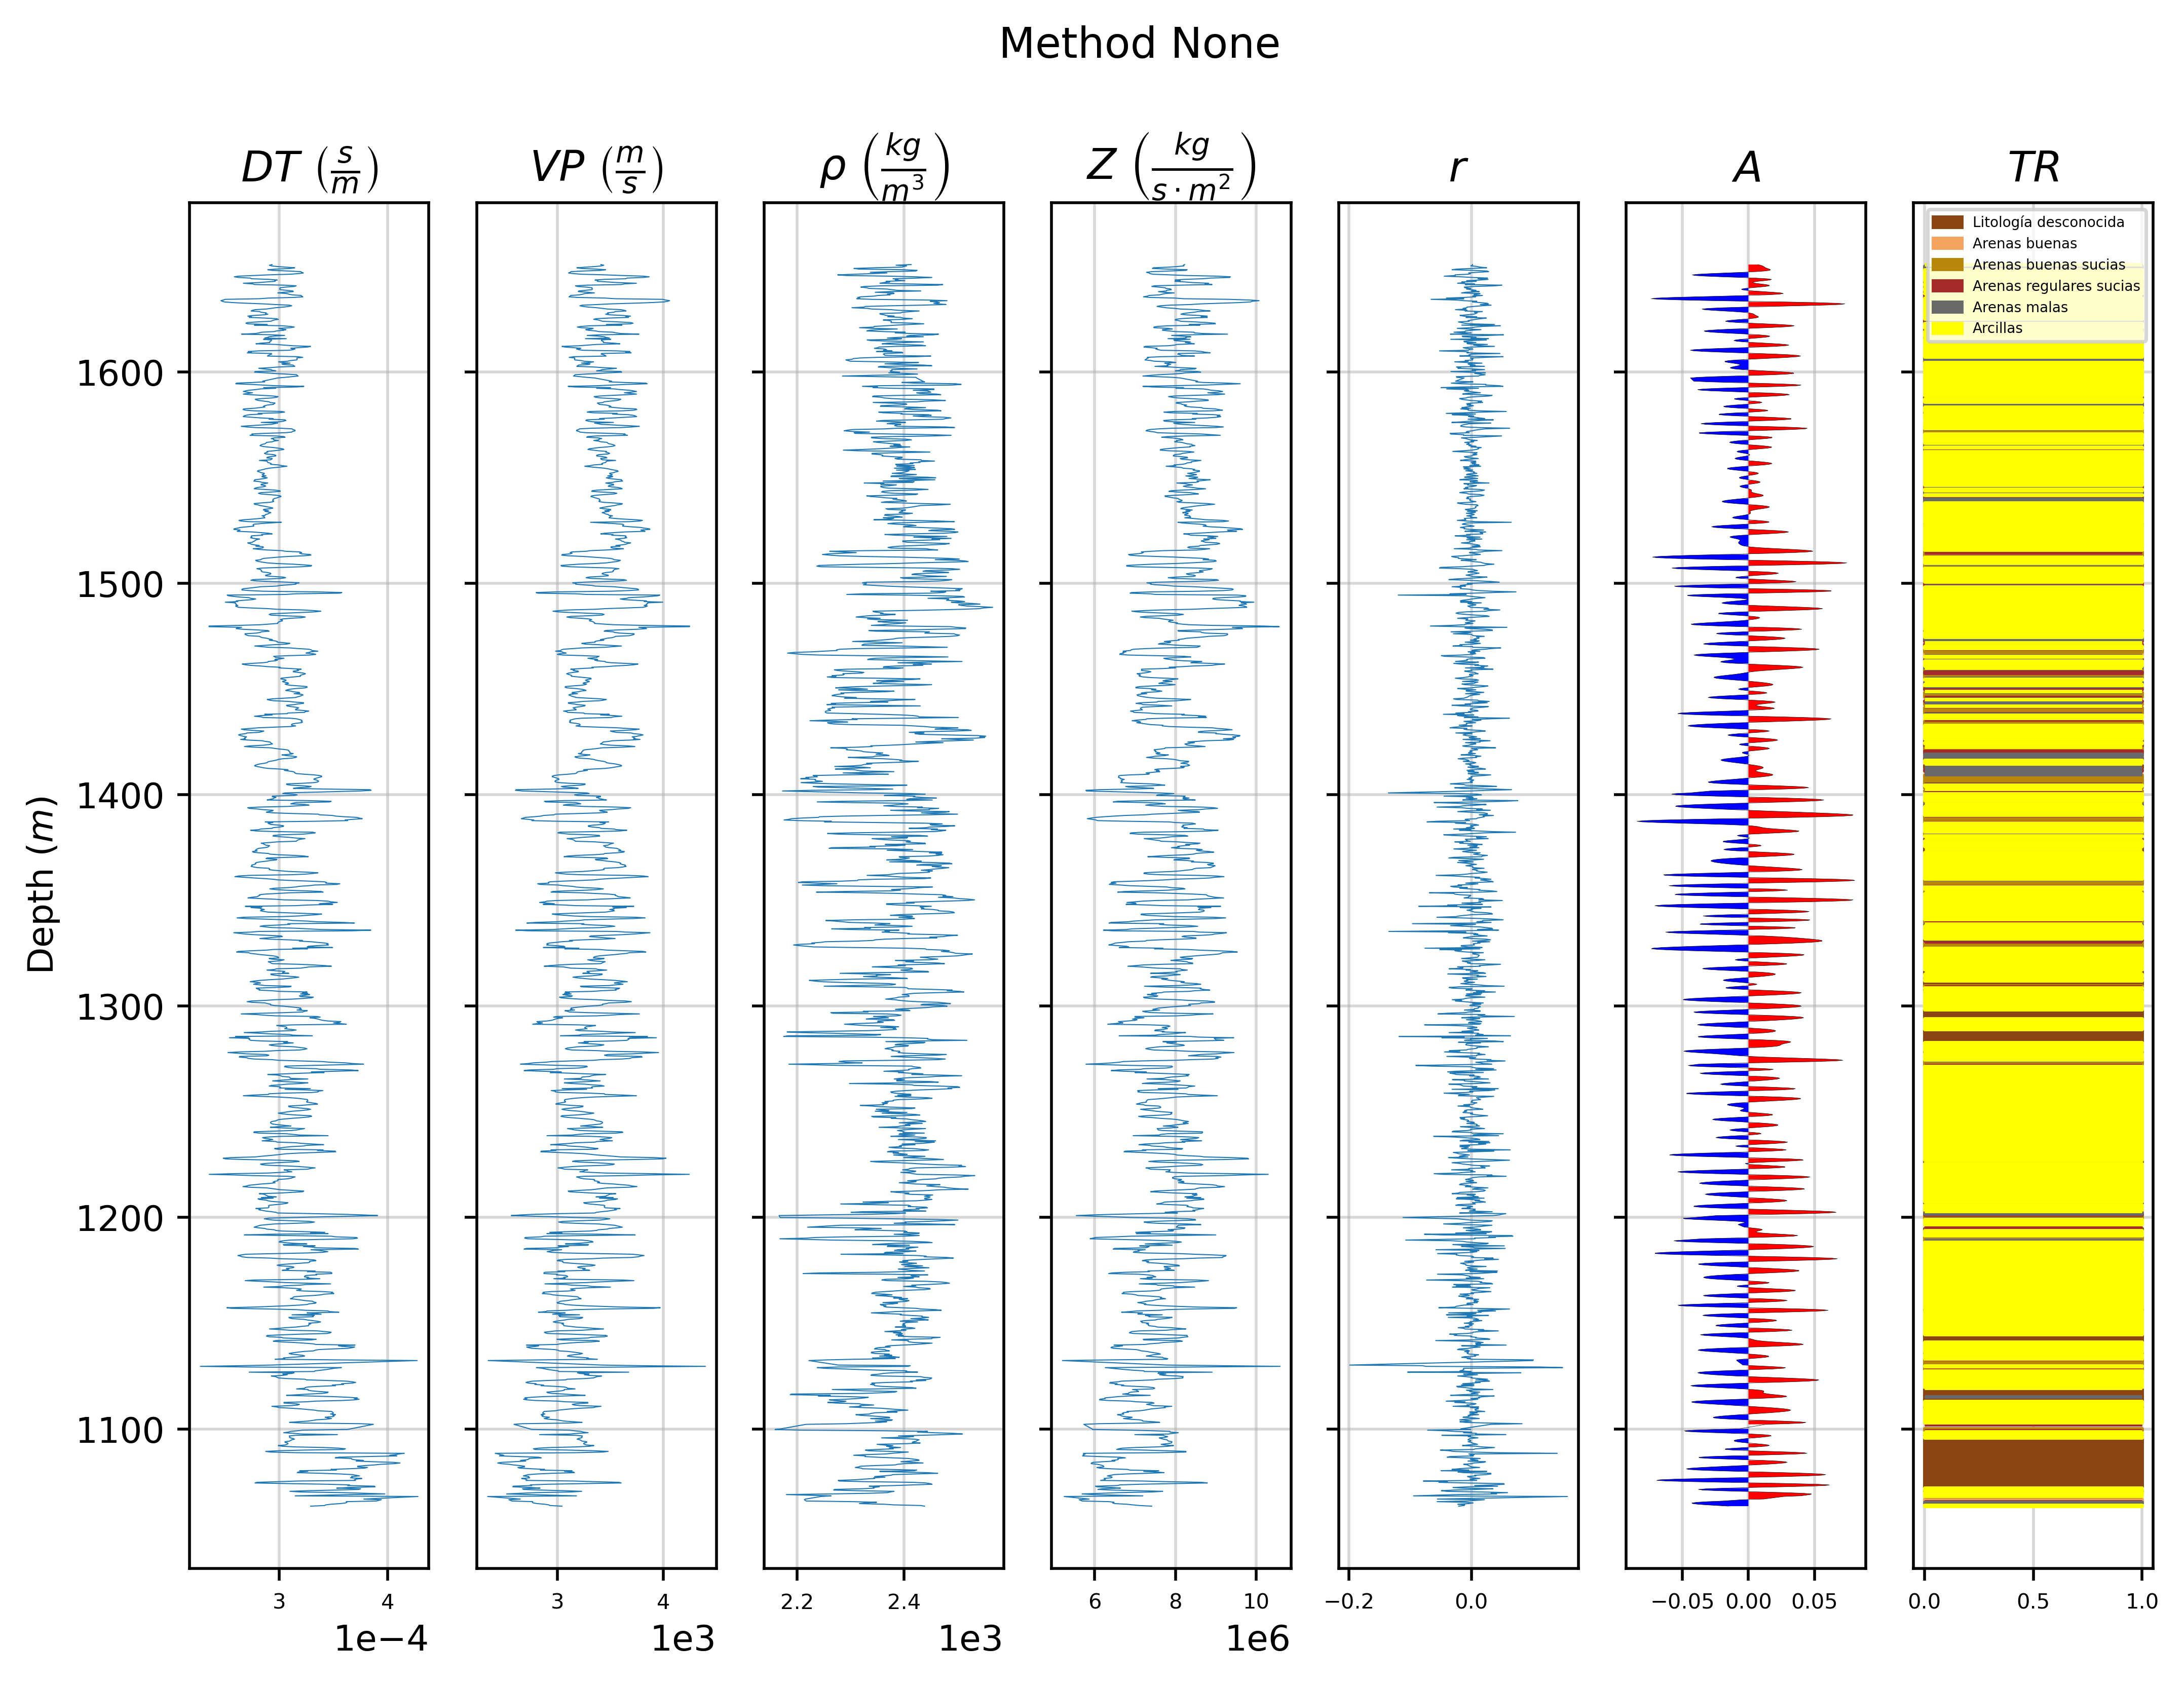

In [33]:
method = None # r any, r < 0.3, r < 0.1, None
r = 'r'
plot_results(df, method, r)

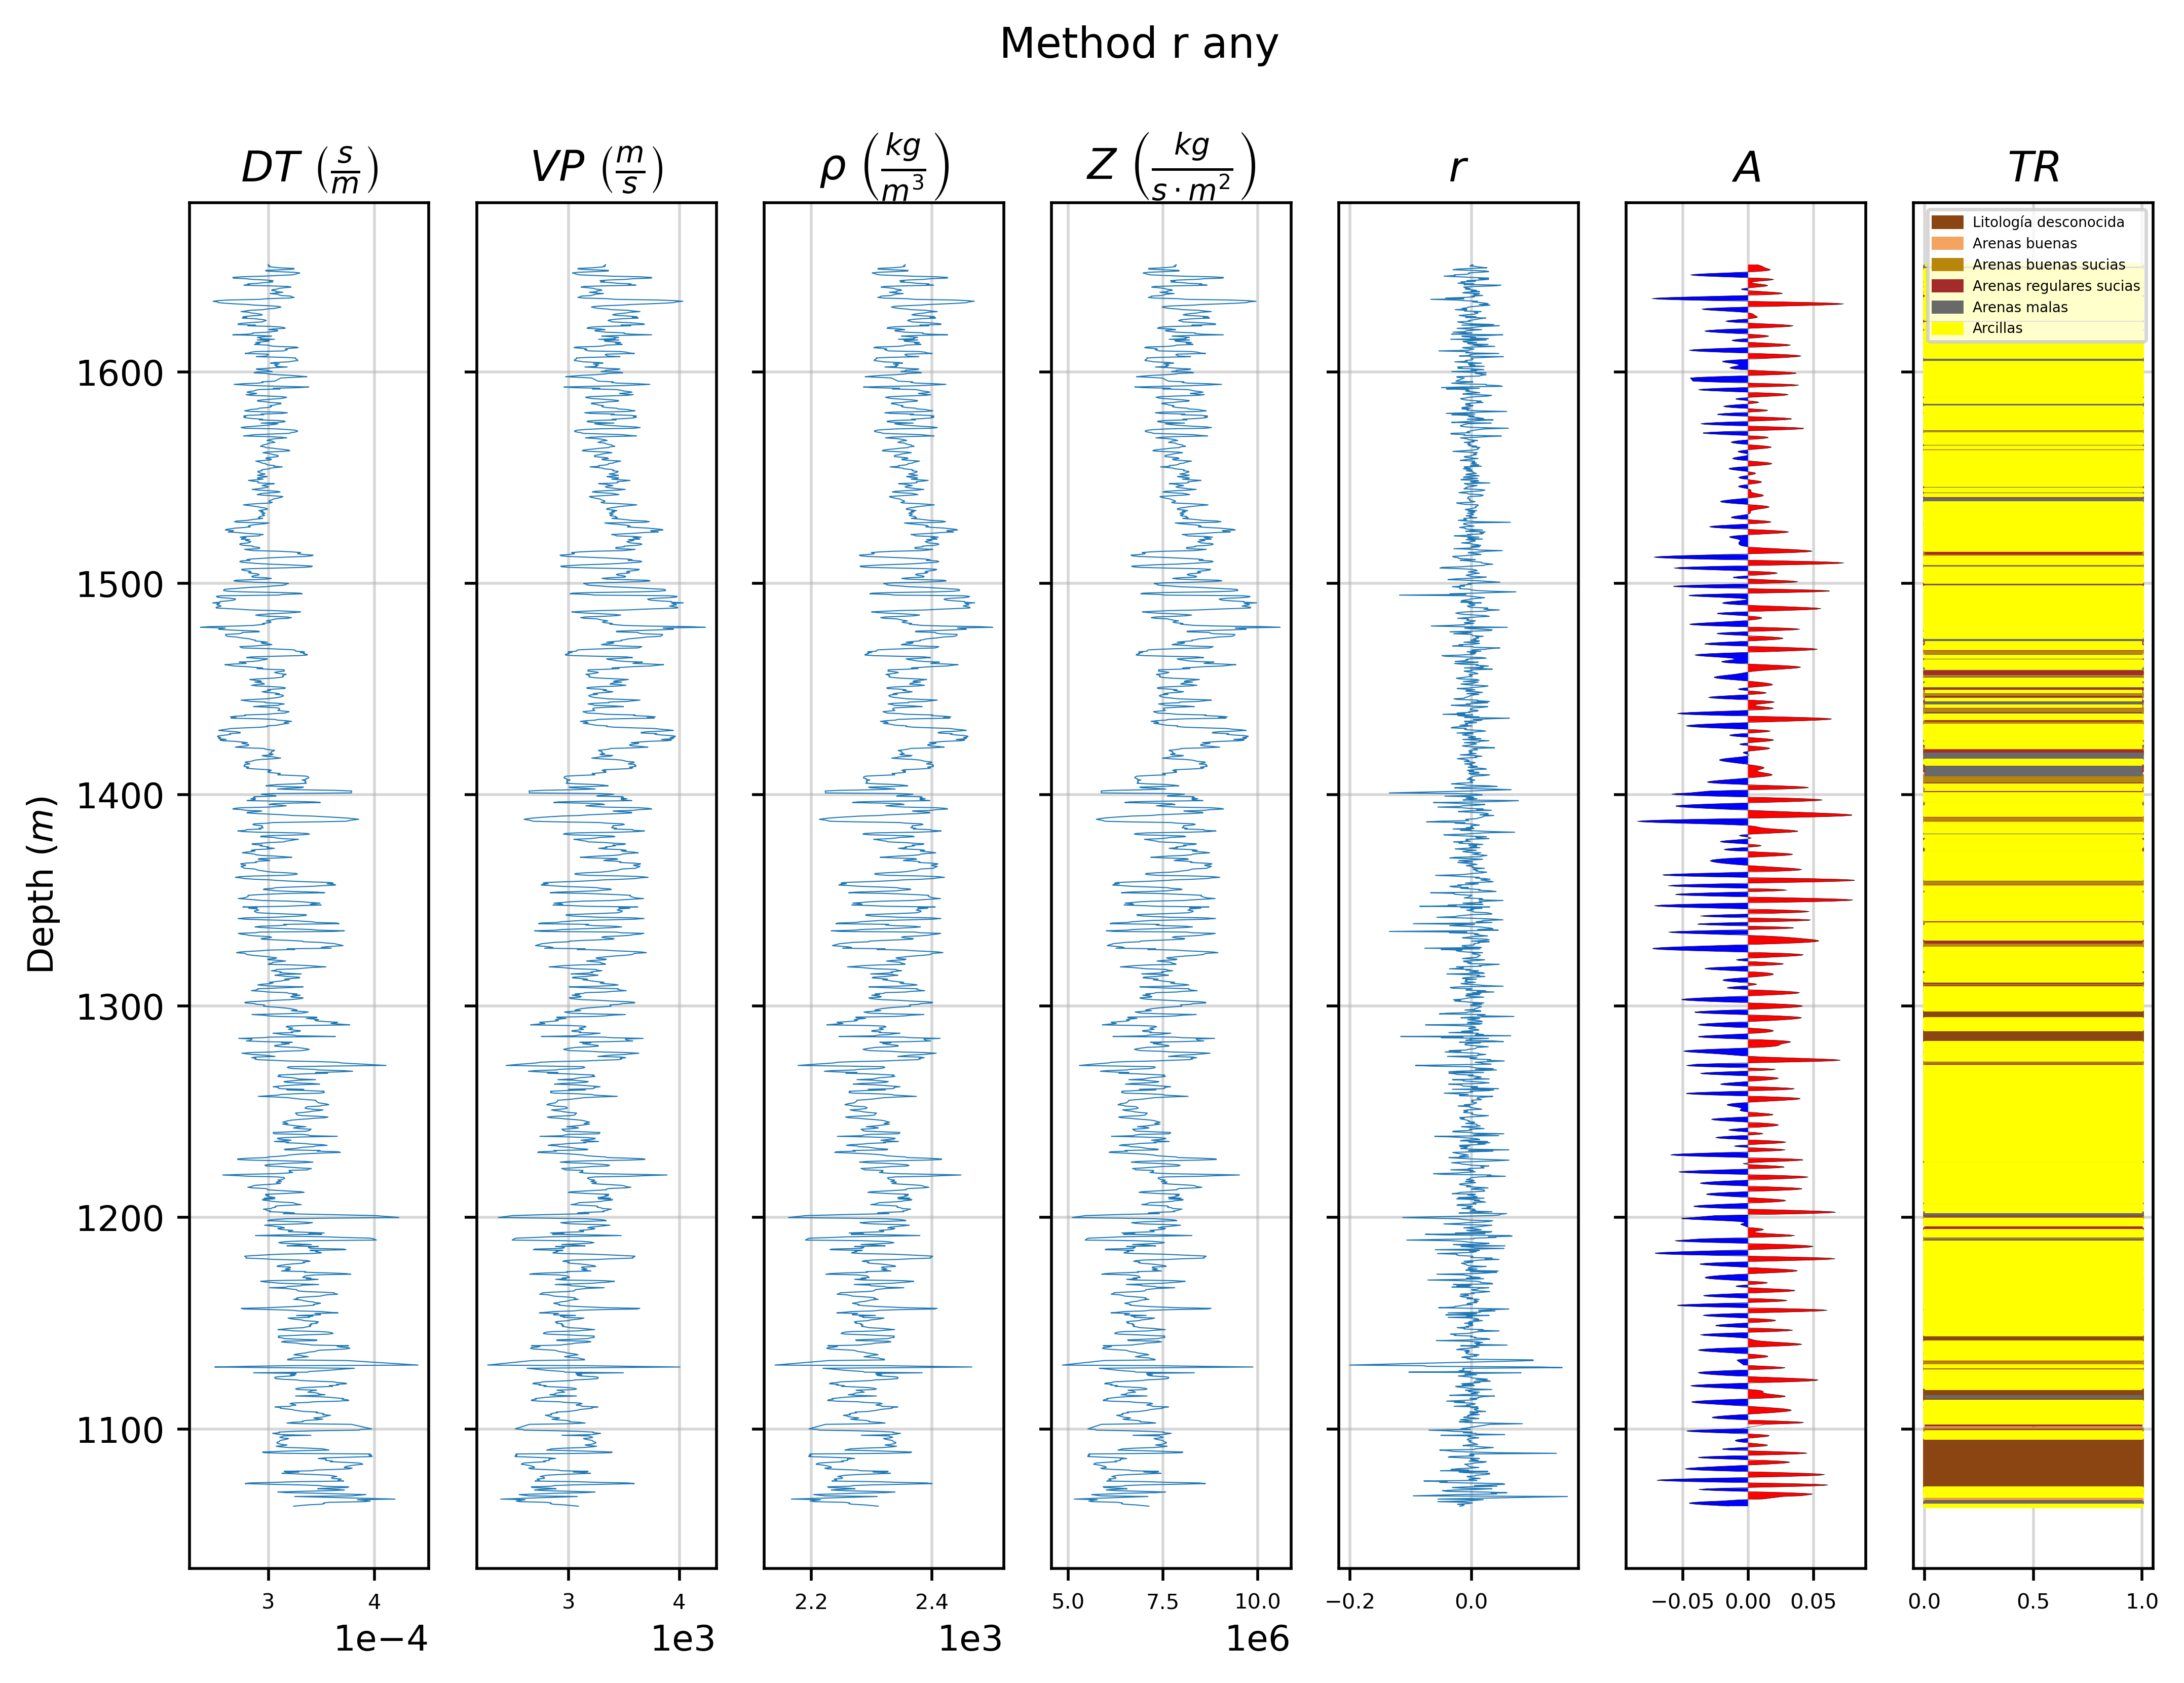

In [34]:
method = 'r any' # r any, r < 0.3, r < 0.1, None
r = 'r_prime'
plot_results(df, method, r)

In [35]:
print('='*50, 'Error for VP', '='*50)
L1_error(df['VP'], df[f'VP_{method}'])
L2_error(df['VP'], df[f'VP_{method}'])
print('='*50, 'Error for RHOB', '='*50)
L1_error(df['RHOB'], df[f'RHOB_{method}'])
L2_error(df['RHOB'], df[f'RHOB_{method}'])
print('='*50, 'Error for Z', '='*50)
L1_error(df['Z'], df[f'Z_{method}'])
L2_error(df['Z'], df[f'Z_{method}'])

================================================== Error for VP ==================================================
================================================== Error for RHOB ==================================================
================================================== Error for Z ==================================================


0.16058806896825537

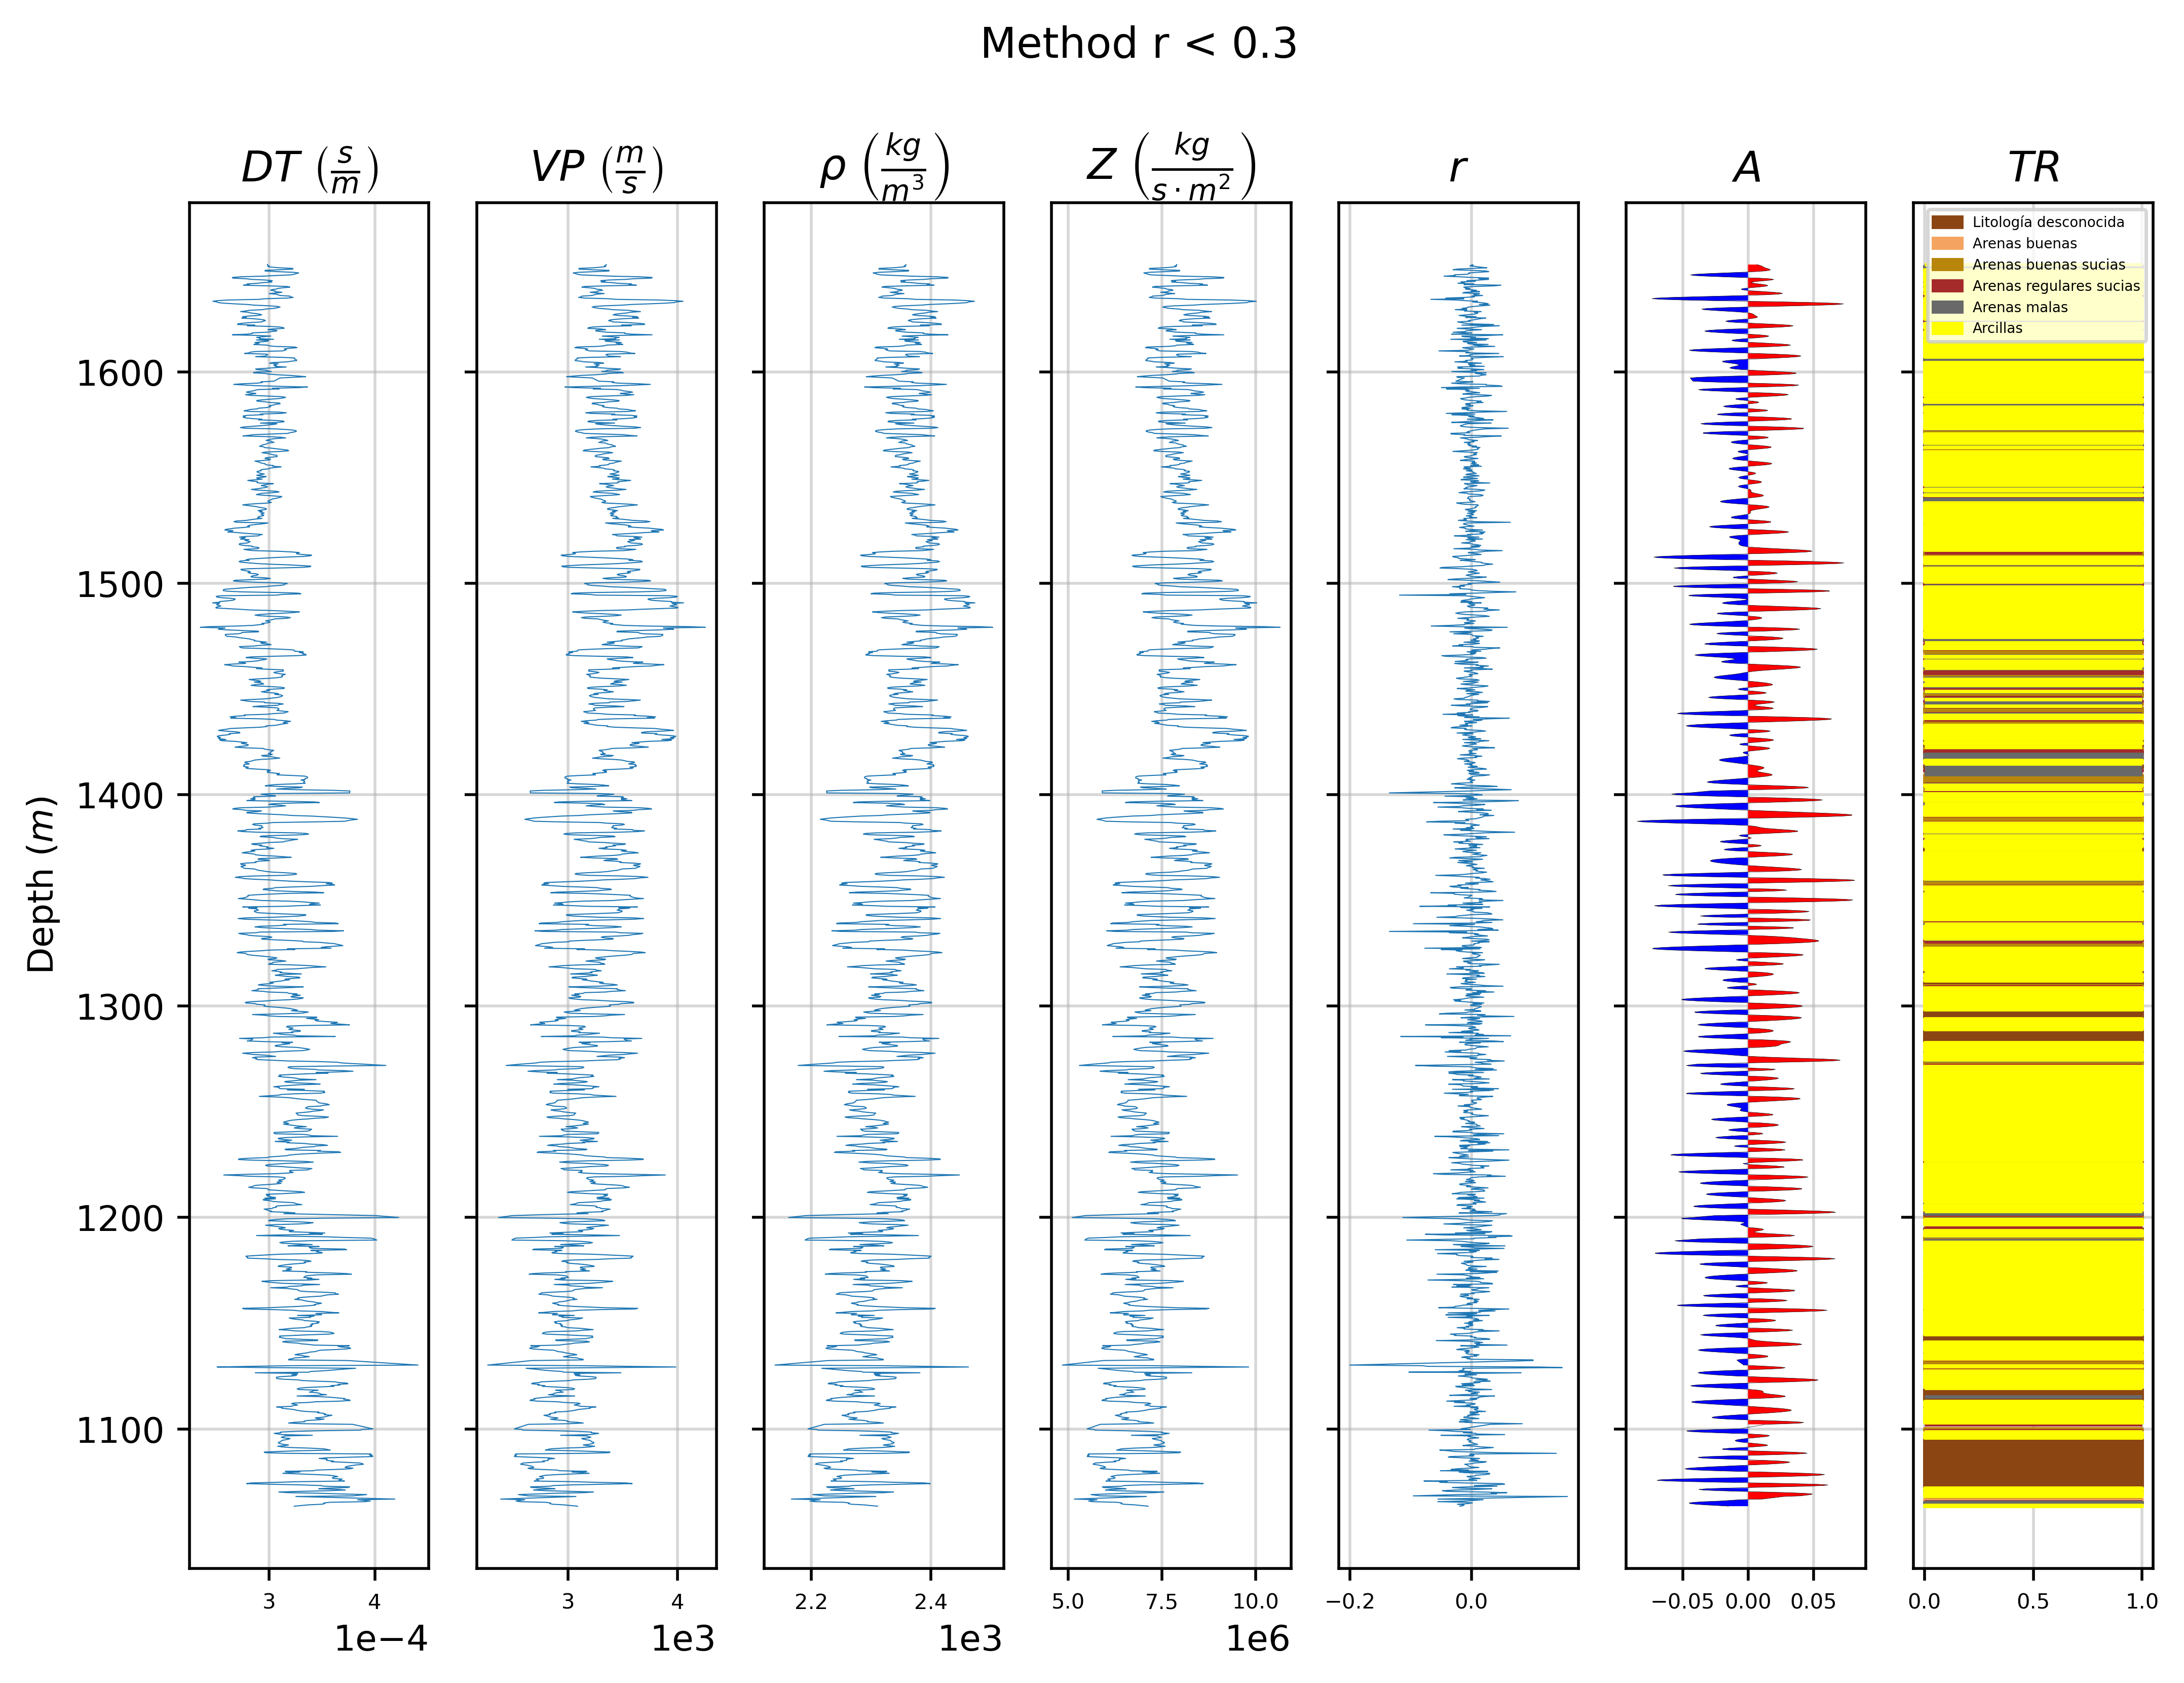

In [36]:
method = 'r < 0.3' # r any, r < 0.3, r < 0.1, None
r = 'r_prime'
plot_results(df, method, r)

In [37]:
print('='*50, 'Error for VP', '='*50)
L1_error(df['VP'], df[f'VP_{method}'])
L2_error(df['VP'], df[f'VP_{method}'])
print('='*50, 'Error for RHOB', '='*50)
L1_error(df['RHOB'], df[f'RHOB_{method}'])
L2_error(df['RHOB'], df[f'RHOB_{method}'])
print('='*50, 'Error for Z', '='*50)
L1_error(df['Z'], df[f'Z_{method}'])
L2_error(df['Z'], df[f'Z_{method}'])

================================================== Error for VP ==================================================
================================================== Error for RHOB ==================================================
================================================== Error for Z ==================================================


0.16048734856904273

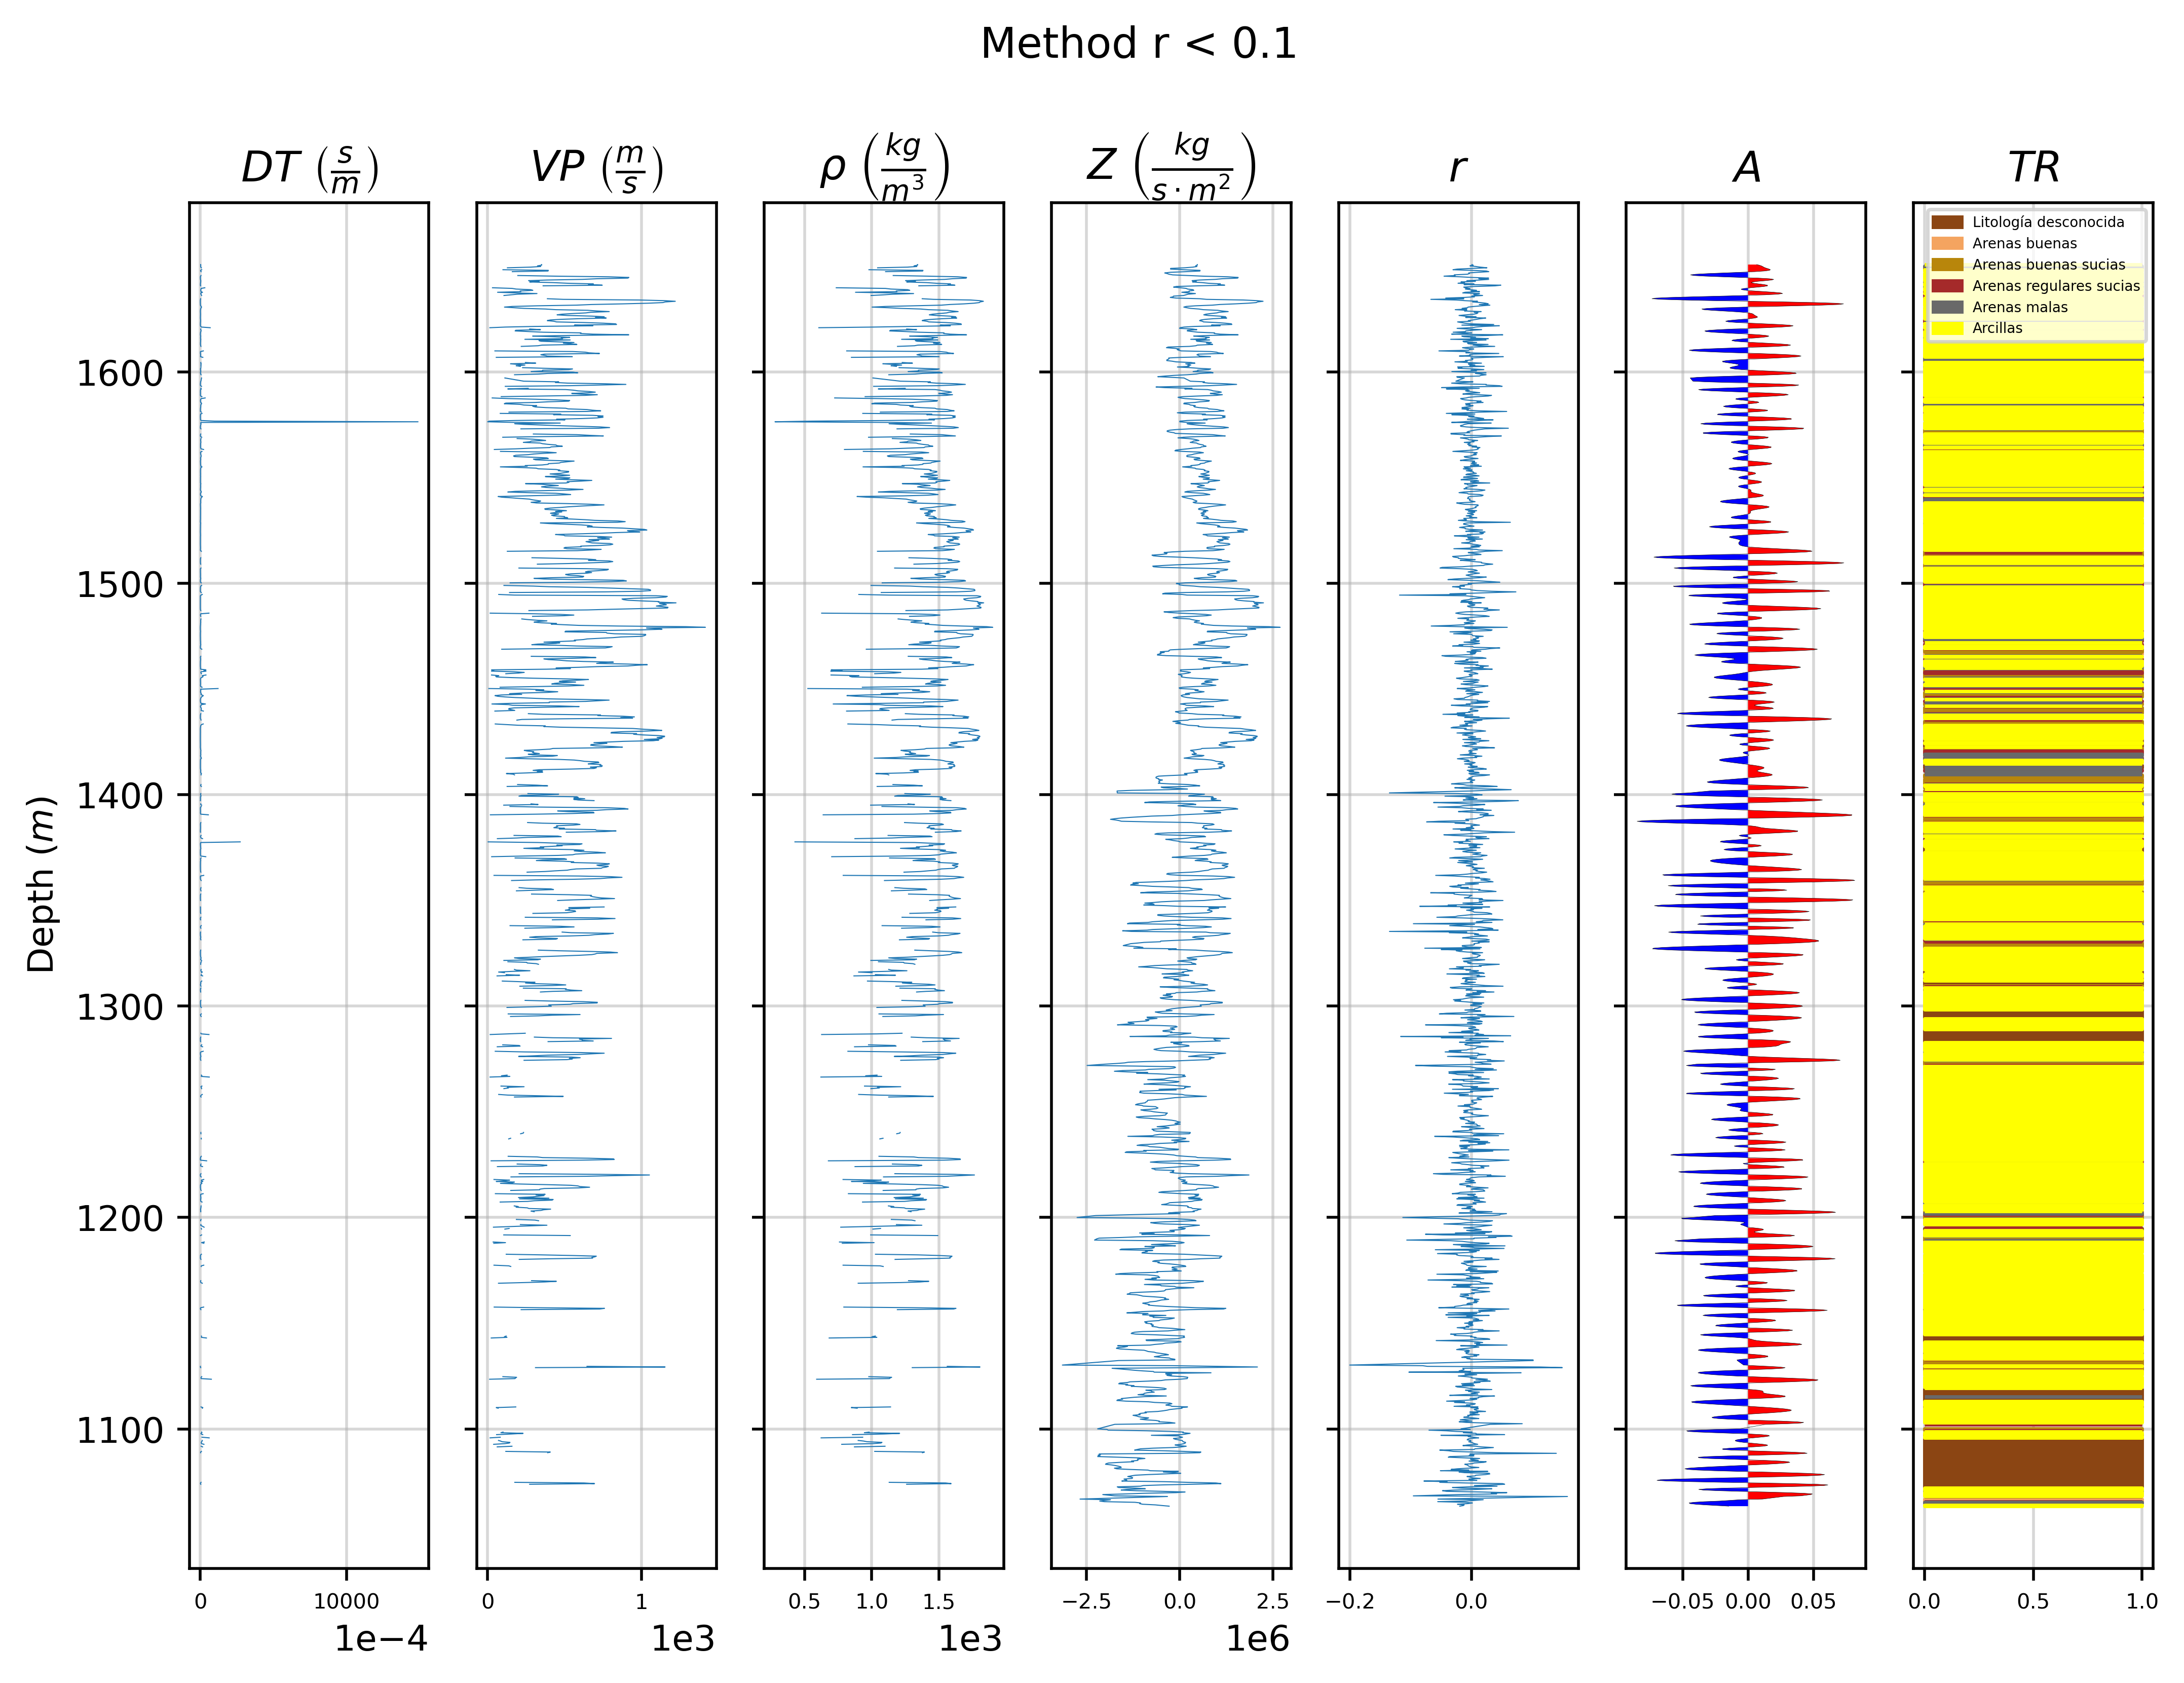

In [38]:
method = 'r < 0.1' # r any, r < 0.3, r < 0.1, None
r = 'r_prime'
plot_results(df, method, r)

In [39]:
print('='*50, 'Error for VP', '='*50)
L1_error(df['VP'], df[f'VP_{method}'])
L2_error(df['VP'], df[f'VP_{method}'])
print('='*50, 'Error for RHOB', '='*50)
L1_error(df['RHOB'], df[f'RHOB_{method}'])
L2_error(df['RHOB'], df[f'RHOB_{method}'])
print('='*50, 'Error for Z', '='*50)
L1_error(df['Z'], df[f'Z_{method}'])
L2_error(df['Z'], df[f'Z_{method}'])

================================================== Error for VP ==================================================
================================================== Error for RHOB ==================================================
================================================== Error for Z ==================================================


2.2924385359147497

#### Calculate Garden relation for each TR

$\rho = aV_p^b$

[2.15980950e+03 1.12452707e-02]


C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


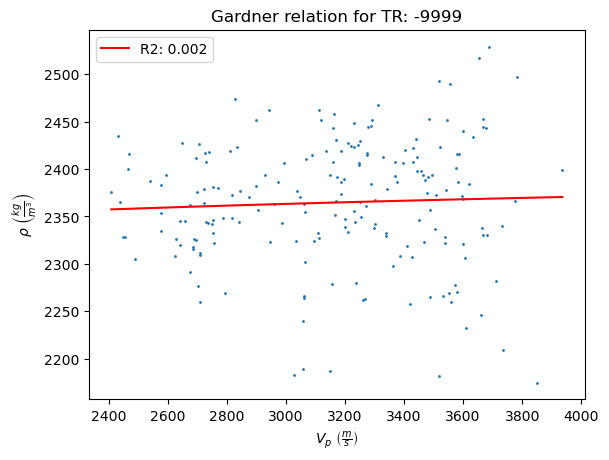

[1.30784432e+03 6.61249453e-02]


C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


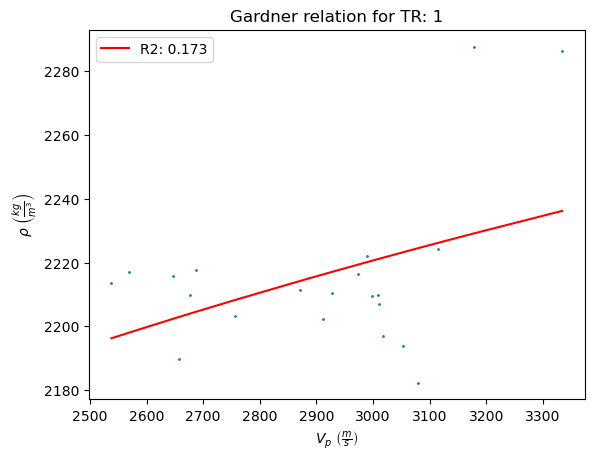

C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


[8.09232681e+02 1.28359095e-01]


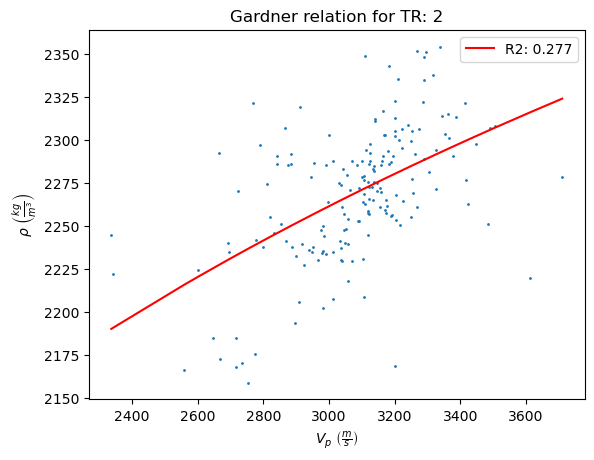

C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


[1.04657135e+03 9.95238067e-02]


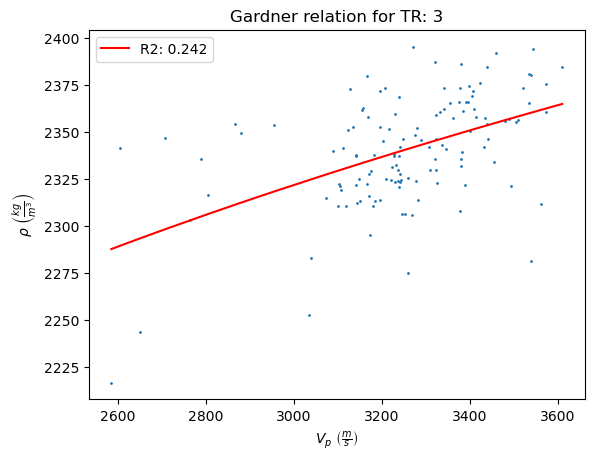

C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


[1.51143709e+03 5.53515196e-02]


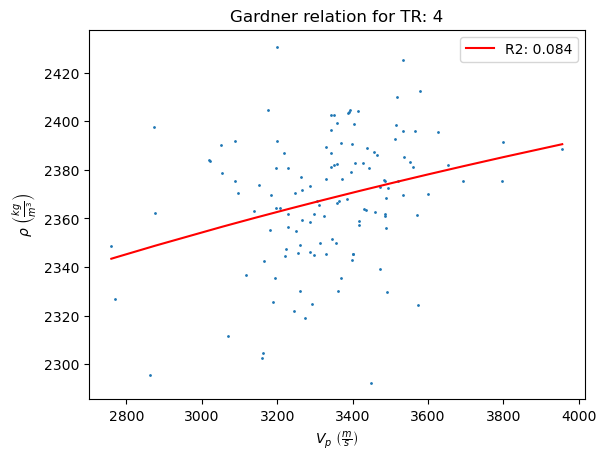

C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


[1.02666171e+03 1.05321606e-01]


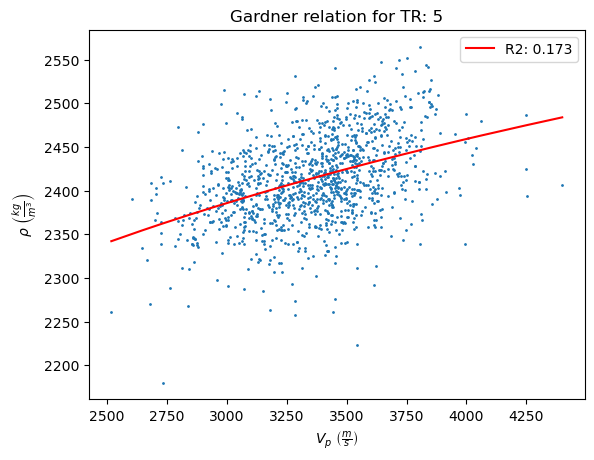

In [40]:
calc_Gardner_relation(df)

#### No Garden relation

$\rho = aZ+b$

[2.08594703e-05 2.20853599e+03]


C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


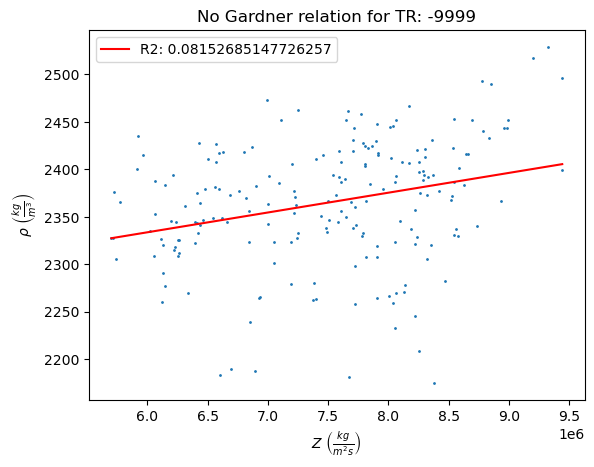

C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


[2.84476117e-05 2.03242427e+03]


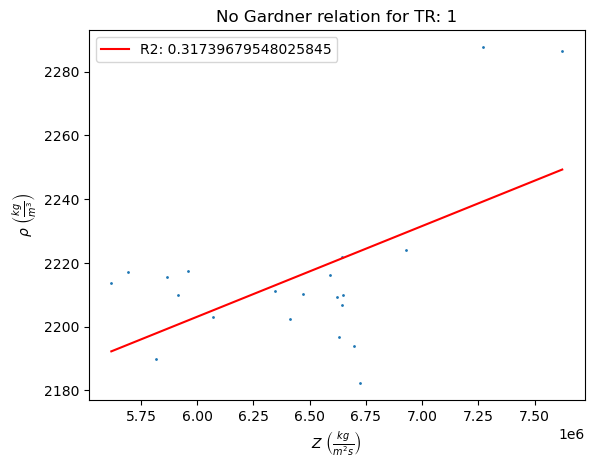

C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


[4.75374521e-05 1.93611284e+03]


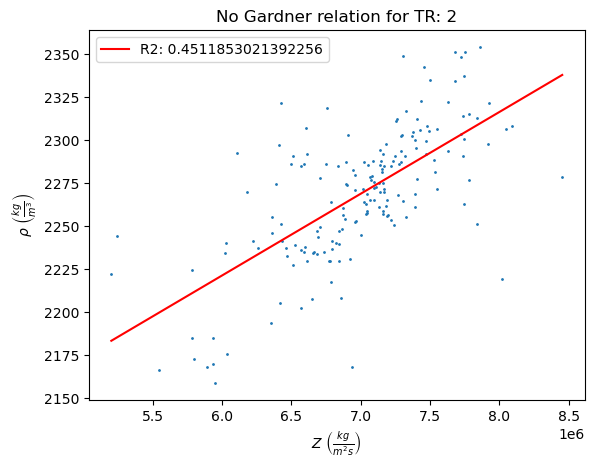

[3.62189517e-05 2.06434544e+03]


C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


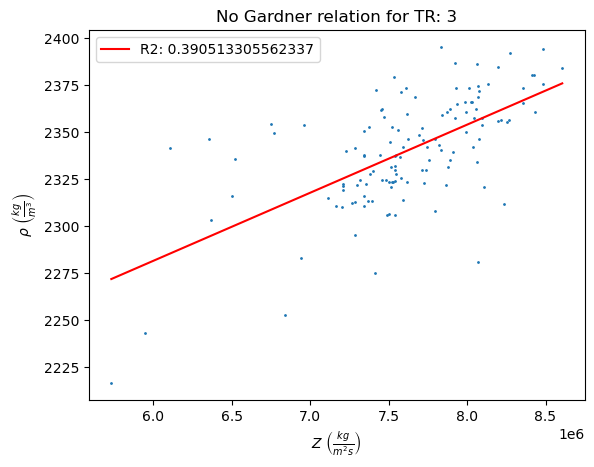

[2.42847487e-05 2.17601430e+03]


C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


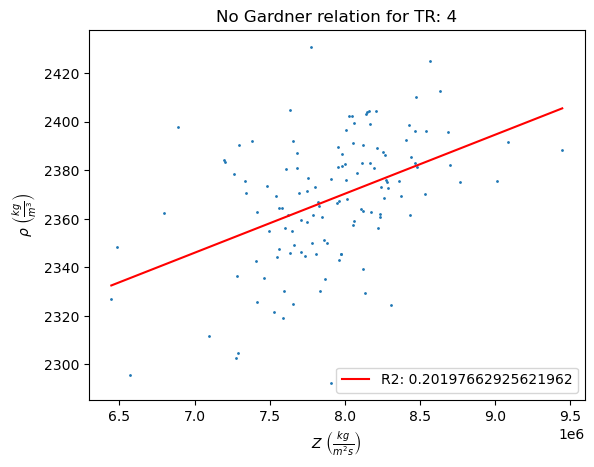

C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


[4.00479181e-05 2.08893174e+03]


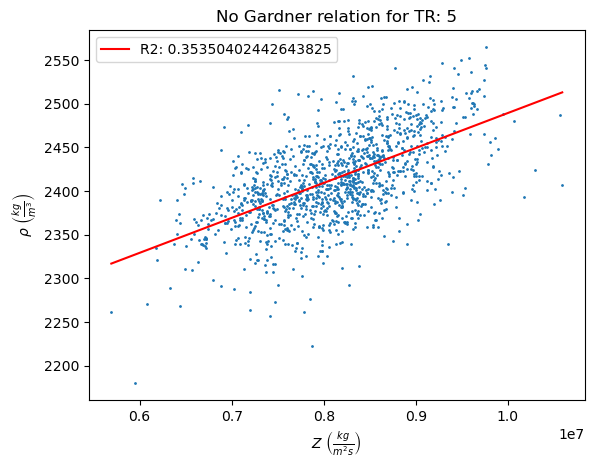

In [41]:
calc_NoGardner_relation(df)

In [42]:
df

DEPT     RHOB  TR           VP             Z         r   r_prime  \
0     1063.4472  2437.95   5  3040.612770  7.412862e+06 -0.020763 -0.019067   
1     1063.7520  2430.98   5  2925.281026  7.111300e+06 -0.011869 -0.013166   
2     1064.0568  2380.59   5  2917.120006  6.944467e+06 -0.010836 -0.011901   
3     1064.3616  2362.44   4  2876.508760  6.795579e+06 -0.022184 -0.022874   
4     1064.6664  2316.35   3  2806.402933  6.500611e+06 -0.004246 -0.005425   
...         ...      ...  ..          ...           ...       ...       ...   
1894  1649.5776  2395.45   3  3271.378671  7.836424e+06  0.014129  0.014636   
1895  1649.8824  2399.41   4  3359.593884  8.061043e+06  0.009245  0.007365   
1896  1650.1872  2404.28   4  3415.357043  8.211475e+06 -0.000863 -0.002313   
1897  1650.4920  2384.71   3  3437.445898  8.197312e+06  0.001770  0.002988   
1898  1650.7968  2413.00   5  3409.190939  8.226378e+06  0.001770  0.000931   

      waveform_r  waveform_r_prime        DT  ...   RHOB_r any  DT_r any  \
0      -0.015018         -0.014772  0.000329  ...  2310.861381  0.000324   
1      -0.023803         -0.024129  0.000342  ...  2298.722969  0.000331   
2      -0.031947         -0.032900  0.000343  ...  2287.805699  0.000337   
3      -0.038465         -0.040013  0.000348  ...  2266.964996  0.000350   
4      -0.042379         -0.044397  0.000356  ...  2262.050522  0.000353   
...          ...               ...       ...  ...          ...       ...   
1894    0.012236          0.012015  0.000306  ...  2347.884975  0.000304   
1895    0.011584          0.011177  0.000298  ...  2354.812076  0.000300   
1896    0.010682          0.010176  0.000293  ...  2352.634196  0.000301   
1897    0.009181          0.008678  0.000291  ...  2355.447850  0.000300   
1898    0.006975          0.006566  0.000293  ...  2355.447850  0.000300   

         Z_r < 0.3   VP_r < 0.3  RHOB_r < 0.3  DT_r < 0.3     Z_r < 0.1  \
0     7.135505e+06  3087.808865   2310.863517    0.000324 -2.826790e+05   
1     6.950068e+06  3023.443804   2298.725794    0.000331 -4.778709e+05   
2     6.786597e+06  2966.417671   2287.809024    0.000337 -6.543106e+05   
3     6.483118e+06  2859.813947   2266.971910    0.000350 -9.934350e+05   
4     6.413150e+06  2835.095950   2262.057469    0.000353 -1.073872e+06   
...            ...          ...           ...         ...           ...   
1894  7.772711e+06  3306.501180   2350.736033    0.000302  3.513881e+05   
1895  7.888049e+06  3345.694948   2357.671420    0.000299  4.605781e+05   
1896  7.851640e+06  3333.334884   2355.490899    0.000300  4.262828e+05   
1897  7.898703e+06  3349.309594   2358.307962    0.000299  4.705836e+05   
1898  7.898703e+06  3349.309594   2358.307962    0.000299  4.705836e+05   

      VP_r < 0.1  RHOB_r < 0.1  DT_r < 0.1  
0            NaN           NaN         NaN  
1            NaN           NaN         NaN  
2            NaN           NaN         NaN  
3            NaN           NaN         NaN  
4            NaN           NaN         NaN  
...          ...           ...         ...  
1894  277.677216   1265.455144    0.003601  
1895  344.788882   1335.826353    0.002900  
1896  324.092459   1315.312434    0.003086  
1897  350.768100   1341.580436    0.002851  
1898  350.768100   1341.580436    0.002851  

[1899 rows x 22 columns]

# DIX Velocity

In [43]:
import numpy as np

In [44]:
# Vint = interval velocity
# t1 = traveltime to the first reflector
# t2 = traveltime to the second reflector
# Vrms1 = root-mean-squre velocity to the first reflector
# Vrms2 = root-mean-squre velocity to the second reflector

def calc_dix(t, Vrms):
    V_int = []
    for i in range(1, len(Vrms)):
        v = np.sqrt((t[i]*Vrms[i]**2-t[i-1]*Vrms[i-1]**2)/(t[i]-t[i-1]))
        V_int.append(v)
    return V_int

# X = offset, distancia entre fuente y receptor

def calc_tx(t0, x, Vrms):
    tx = np.sqrt(t0**2 + x**2/Vrms**2)
    return tx

def give_params():
    
    alpha = 310
    beta = 0.25
        
    return alpha, beta

def calc_rho(Vint):
    
    alpha, beta = give_params()   
    rho = alpha*Vint**beta
    
    return rho

def calc_r(m0, j=999):
    
    if j != 999:
        r = (m0[j+1] - m0[j])/(m0[j+1] + m0[j])
    else:
        r = []
        for i in range(1, len(m0)):

            num = m0[i] - m0[i-1]
            den = m0[i] + m0[i-1]
            r_temp = num/den
            r.append(r_temp)
        r = np.array(r)
    
    return r

1. Para cada reflector yo hago un plot de tiempo vs x offset, el cual me da la velocidad Vrms y t0.
2. Uso el t0 y el Vrms para calcular la velocidad intervalica usando la formula de DIX. 

In [45]:
Vrms = np.array([5.0, 5.2, 5.25, 5.4, 5.8])*1e3 # m/s
print(Vrms.shape)
t = np.array([1,2,3,4,5])*1e-3 # s
print(t.shape)
Vint = np.array(calc_dix(t, Vrms))
print('Interval velocity Vp (m/s): ', Vint)

rho = calc_rho(Vint)
print('Density (kg/m3): ', rho)
Z = Vint*rho
print('Impedance (Rayls kg/(m2*s)): ', Z)
r = calc_r(Z)
print(r)

(5,)
(5,)
Interval velocity Vp (m/s):  [5392.58750509 5348.59794713 5826.87737987 7180.52922841]
Density (kg/m3):  [2656.50718031 2651.07297266 2708.44900823 2853.65066737]
Impedance (Rayls kg/(m2*s)):  [14325447.42770011 14179523.45925434 15781800.26058372 20490722.02471418]
[-0.00511925  0.05347817  0.12982063]


Now that we have the real data. Apply MBI method to calculate a good model of Z's. Merge the notebooks and create a library to manage all functions from there.

# Real examples

In [46]:
def calc_r(df):
    temp = []
    for i in range(1, len(df['Z'])):
        num = df['Z'][i]-df['Z'][i-1]
        den = df['Z'][i]+df['Z'][i-1]
        val = num/den
        temp.append(val)
        if i == len(df['Z'])-1:
            temp.append(temp[-1])
            
    df['r'] = temp
    
    return df

In [47]:
dict_names = {1: 'Arenas buenas', 2: 'Arenas buenas sucias', 3: 'Arenas regulares sucias', 4: 'Arenas malas', 5:'Arcillas', -9999: 'Litología desconocida'}

path_data = "D:\\Users\\serfe\\Desktop\\Maestria geofísica\\1- Semestre 202302\\Inversión sísmica\\0 - Tasks\\Ejercicio Sismica de Reflexion II.csv"
df = pd.read_csv(path_data, sep=';')
# convert units to SI
current_units = {'DEPT':True, 'RHOB':True, 'VP':True, 'DT':False, }
df = SI_conversion(df, current_units)
print(f'Length of original data: {len(df)}')

# Remove outliers from all columns
df = remove_outliers(df[['DEPT', 'RHOB', 'TR', 'VP']], threshold=3)
print(f'Length of filtered data (without outliers): {len(df)}')

### calculate Z and r
df = calc_Z(df)
df = calc_r(df)
df = calc_r_prime(df, 1/100)
# calculate the waveform
method = 'r'
df = wavelet_conv(df, method)
method = 'r_prime'
df = wavelet_conv(df, method)
# calculate DT
df = calc_sonic(df, None)

Length of original data: 1928
Length of filtered data (without outliers): 1899


In [48]:
def calc_r(m0, j=999):
    
    if j != 999:
        r = (m0[j+1] - m0[j])/(m0[j+1] + m0[j])
    else:
        r = []
        for i in range(1, len(m0)):

            num = m0[i] - m0[i-1]
            den = m0[i] + m0[i-1]
            r_temp = num/den
            r.append(r_temp)
        r = np.array(r)
    
    return r

In [49]:
def MBI(m0, r0, r, step=0.01, max_iter=20, regularization_coeff=0.1):
    # Initialize variables and setup
    
    for i in range(max_iter):
        # Calculate Jacobian matrix G
        G = calc_G(m0, r0, r, step=step)
        
        # Compute regularization term
        regularization_term = regularization_coeff * np.eye(len(m0))
        
        # Update impedance model m0 using the regularized inverse
        m0 -= np.linalg.inv(G.T @ G + regularization_term) @ G.T @ (r - r0)
        
        # Update r0 based on the updated m0
        r0 = calc_r(m0)
        
        # Calculate and print errors
        L1 = L1_error(r, r0)
        L2 = L2_error(r, r0)
        print(f'Iteration {i + 1}: L1 error={L1}, L2 error={L2}')
        
        early_stop_error = 10
        # Check for convergence based on error thresholds
        if L1 < early_stop_error and L2 < early_stop_error:
            break
    
    # Print results
    print(f'Converged after {i + 1} iterations')
    print(f'Final L1 error: {L1}')
    print(f'Final L2 error: {L2}')
    
    return m0, r0


In [50]:
m0 = np.random.rand(len(df['r'])+1)
m0 = m0.reshape(len(m0),1) # model initial guess
r0 = calc_r(m0) # model initial guess
r = np.array(df['r'].values).reshape(len(r0), 1) # real reflectivity profile
m_predicted, r_predicted = MBI(m0, r0, r, step=.01, max_iter=1000)

Iteration 1: L1 error=4785.704633608732, L2 error=925.3462950561989
Iteration 2: L1 error=906.5151912433587, L2 error=198.29171197986776
Iteration 3: L1 error=250.30406142270834, L2 error=35.56094502342235
Iteration 4: L1 error=158.49773150428993, L2 error=26.982322311006655
Iteration 5: L1 error=125.00819531216776, L2 error=21.533911482510096
Iteration 6: L1 error=107.02104507926352, L2 error=17.749177754771797
Iteration 7: L1 error=94.93677445284247, L2 error=15.256208025341916
Iteration 8: L1 error=85.74641926521112, L2 error=13.550054994490953
Iteration 9: L1 error=78.26606341806036, L2 error=12.311582502278117
Iteration 10: L1 error=72.03103755452229, L2 error=11.359382603243603
Iteration 11: L1 error=66.81581568884832, L2 error=10.590647236759063
Iteration 12: L1 error=62.37317828686759, L2 error=9.945579391341685
Iteration 13: L1 error=58.42935194735179, L2 error=9.388311278351372
Iteration 14: L1 error=55.063917624289374, L2 error=8.896679631228535
Iteration 15: L1 error=52.274

KeyboardInterrupt: 

In [51]:
def calc_Vs(Vp): # Vs
    Vs = Vp/(np.sqrt(4/3))
    return Vs

In [52]:
def calc_mu(Vs, rho): # Shear modulus
    mu = (Vs**2)*rho
    return mu

In [53]:
def calc_k(Vp, rho, mu): # bulk modulus 
    k = (Vp**2 * rho) - (4/3 * mu)
    return k

In [54]:
rho = df['RHOB']
rho

0       2437.95
1       2430.98
2       2380.59
3       2362.44
4       2316.35
         ...   
1894    2395.45
1895    2399.41
1896    2404.28
1897    2384.71
1898    2413.00
Name: RHOB, Length: 1899, dtype: float64

In [55]:
Vp = df['VP']
Vp

0       3040.612770
1       2925.281026
2       2917.120006
3       2876.508760
4       2806.402933
           ...     
1894    3271.378671
1895    3359.593884
1896    3415.357043
1897    3437.445898
1898    3409.190939
Name: VP, Length: 1899, dtype: float64

In [56]:
Vs = calc_Vs(Vp)
Vs

0       2633.247902
1       2533.367681
2       2526.300031
3       2491.129660
4       2430.416234
           ...     
1894    2833.097035
1895    2909.493650
1896    2957.785962
1897    2976.915472
1898    2952.445959
Name: VP, Length: 1899, dtype: float64

In [57]:
mu = calc_mu(Vs, rho)
mu

0       1.690473e+10
1       1.560191e+10
2       1.519338e+10
3       1.466066e+10
4       1.368250e+10
            ...     
1894    1.922693e+10
1895    2.031137e+10
1896    2.103384e+10
1897    2.113336e+10
1898    2.103397e+10
Length: 1899, dtype: float64

In [58]:
k = calc_k(Vp, rho, mu)
k

0       0.000000
1       0.000000
2      -0.000004
3      -0.000008
4       0.000004
          ...   
1894    0.000004
1895   -0.000004
1896   -0.000011
1897    0.000000
1898   -0.000004
Length: 1899, dtype: float64